In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glhmm.glhmm as glhmm
import seaborn as sns
import network_tools as nt
import importlib
import networkx as nx
import dynamics as dyn
from scipy.linalg import eig
import csv
from sklearn.cluster import KMeans,MiniBatchKMeans
import statespacesplitting as sss
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib
import hmm_helper as hmmh
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
importlib.reload(nt)
importlib.reload(dyn)
importlib.reload(sss)
importlib.reload(hmmh)

<module 'hmm_helper' from '/Users/ramon/Desktop/Year 2/hmm/hmm_helper.py'>

In [4]:
N = 100
W = nt.generate_hierarchical_network(N,mu = 0.2,p0 = 1,recip = 10)

In [5]:
Theta = 1
gamma = 0.1
sigma = 0.05
dt = 0.05
steps = 1000
print(np.real(np.linalg.eig(Theta*(np.diag(np.ones(N))-gamma*W)).eigenvalues)>0)
Phi = dyn.EPR_network_ornstein_uhlenbeck(W,sigma,Theta,gamma)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In [6]:
[X,t] = dyn.network_ornstein_uhlenbeck(nt.parameterise_network(W,1),sigma,Theta,gamma,dt,steps)
tau = 20
X_sampled = X[:,0::tau]
t_sampled= t[0::tau]

In [14]:
sc = StandardScaler()
X_std = sc.fit_transform(np.transpose(X))
pca = PCA(n_components=3)
X_pca = pca.fit(X_std)
X_pca = np.transpose(pca.transform(X_std))

/Users/ramon/opt/anaconda3/envs/hmm/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ramon/opt/anaconda3/envs/hmm/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ramon/opt/anaconda3/envs/hmm/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ramon/opt/anaconda3/envs/hmm/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

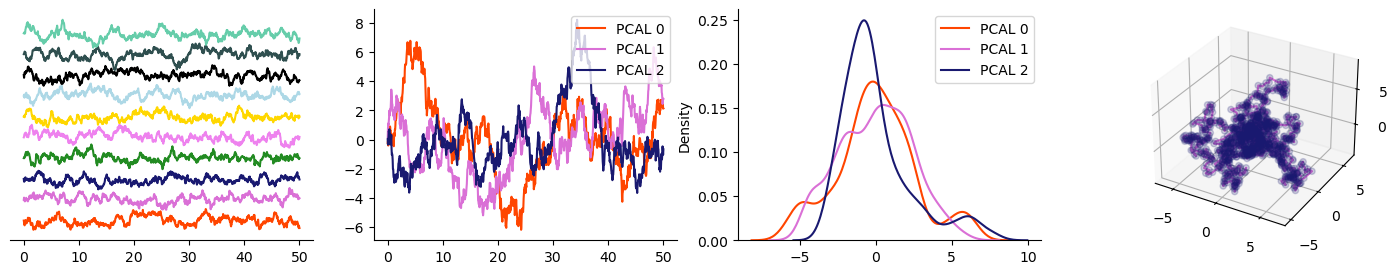

<Figure size 640x480 with 0 Axes>

In [43]:
fig = plt.figure()
axs=[0,0,0,0]
axs[0] = fig.add_subplot(1,4,1)
axs[1] = fig.add_subplot(1,4,2)
axs[3] = fig.add_subplot(1,4,4,projection='3d')
axs[2] = fig.add_subplot(1,4,3)
fig.set_size_inches(18,3)
colours =['orangered','orchid','midnightblue','forestgreen','violet','gold','lightblue','black','darkslategrey','mediumaquamarine']
for i in range(0,10):
    sns.lineplot(x=t,y=X[i,:]+2*i,ax=axs[0],color=colours[i])
    sns.despine()

ax = plt.gca()
ax.spines["bottom"].set_visible(False)
for i in range(0,3):
    sns.lineplot(x=t,y=X_pca[i,:],ax=axs[1],color=colours[i],label= 'PCAL ' + str(i))
    sns.kdeplot(X_pca[i,:],ax=axs[2],color=colours[i],label= 'PCAL ' + str(i))
    sns.despine()
axs[3].plot(X_pca[0,:], X_pca[1,:], X_pca[2,:], color = 'orchid')
axs[3].scatter(X_pca[0,:], X_pca[1,:], X_pca[2,:], color = 'midnightblue',alpha=0.2)
axs[0].set_yticklabels([])
axs[0].set_yticks([])
ax = plt.gca()
axs[0].spines["left"].set_visible(False)
axs[1].legend()
sns.move_legend(axs[1], "upper right")
axs[2].legend()
plt.show()
sns.despine()
plt.tight_layout()
plt.show()

# Coarse-graining

/var/folders/j3/3jf2wkbj5756yfdv4zjq5j300000gn/T/ipykernel_10588/1540578541.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma_r')


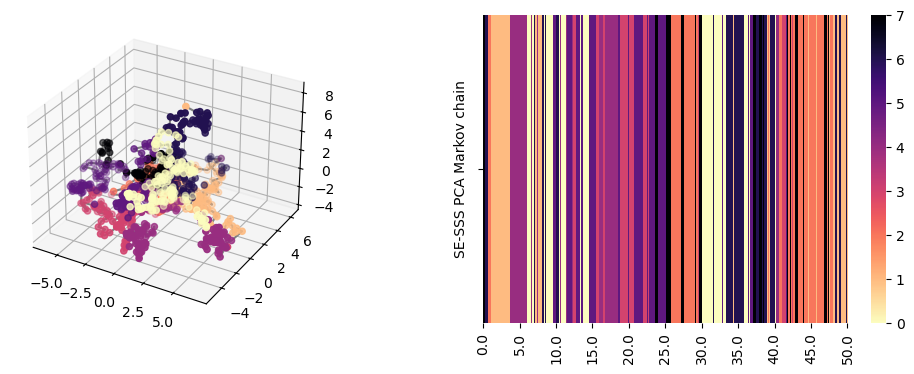

In [48]:
box_tc, box_idx_tc = sss.state_space_split(X_pca,3,sss.boundary_list_stat_even(X_pca,[2,2,2]))
colours =['orangered','orchid','midnightblue','forestgreen','violet','gold','lightblue','black']
fig = plt.figure()
fig.set_size_inches(20,4)
axs=[0,0]
axs[1] = fig.add_subplot(1,3,2)
axs[0] = fig.add_subplot(1,3,1,projection='3d')
bidx = np.array(box_idx_tc)
for i in range(0,8):
    cmap = matplotlib.cm.get_cmap('magma_r')
    rgba = cmap(i/7)
    axs[0].scatter(X_pca[0,np.where(bidx==i)[0]], X_pca[1,np.where(bidx==i)[0]], X_pca[2,np.where(bidx==i)[0]], color = rgba)
axs[0].plot(X_pca[0,], X_pca[1,], X_pca[2,], color = 'grey')
df = pd.DataFrame({"SSS":box_idx_tc},index =t)
sns.heatmap(np.transpose(df),cmap='magma_r',ax=axs[1])
axs[1].set_xticks(np.linspace(0,1000,11))
axs[1].set_xticklabels(np.linspace(0,50,11))
axs[1].set_yticklabels('')
axs[1].set_ylabel('SE-SSS PCA Markov chain')
plt.show()
SE_SSS_TP = dyn.markov_chain_to_TP(box_idx_tc,8)

/var/folders/j3/3jf2wkbj5756yfdv4zjq5j300000gn/T/ipykernel_10588/525315037.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma_r')


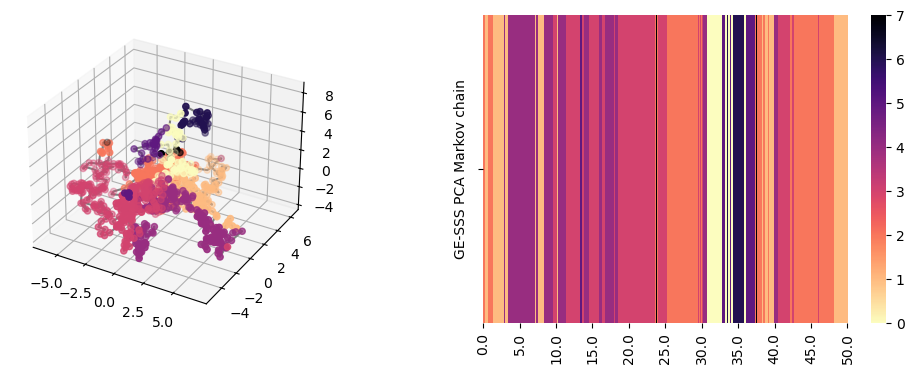

In [49]:
box_tc, box_idx_tc = sss.state_space_split(X_pca,3,sss.boundary_list_geom_even(X_pca,[2,2,2]))
fig = plt.figure()
fig.set_size_inches(20,4)
axs=[0,0]
axs[1] = fig.add_subplot(1,3,2)
axs[0] = fig.add_subplot(1,3,1,projection='3d')
bidx = np.array(box_idx_tc)
for i in range(0,8):
    cmap = matplotlib.cm.get_cmap('magma_r')
    rgba = cmap(i/7)
    axs[0].scatter(X_pca[0,np.where(bidx==i)[0]], X_pca[1,np.where(bidx==i)[0]], X_pca[2,np.where(bidx==i)[0]], color = rgba)
axs[0].plot(X_pca[0,], X_pca[1,], X_pca[2,], color = 'grey')
df = pd.DataFrame({"SSS":box_idx_tc},index =t)
sns.heatmap(np.transpose(df),cmap='magma_r',ax=axs[1])
axs[1].set_xticks(np.linspace(0,1000,11))
axs[1].set_xticklabels(np.linspace(0,50,11))
axs[1].set_yticklabels('')
axs[1].set_ylabel('GE-SSS PCA Markov chain')
plt.show()
GE_SSS_TP = dyn.markov_chain_to_TP(box_idx_tc,8)

Init repetition 1 free energy = 39139.284719621035
Init repetition 2 free energy = 37676.21380707451
Init repetition 3 free energy = 36688.46077198198
Init repetition 4 free energy = 39381.950197996994
Init repetition 5 free energy = 38331.436709363
Best repetition: 3
Cycle 1 free energy = 36884.081739108304
Cycle 2 free energy = 36687.955334603226
Cycle 3, free energy = 36687.94850544907, relative change = 3.4818954576996046e-05
Cycle 4, free energy = 36687.94847700262, relative change = 1.4503636281194105e-07
Cycle 5, free energy = 36687.948476145066, relative change = 4.372290693629092e-09
Cycle 6, free energy = 36687.94847604041, relative change = 5.336033913135134e-10
Cycle 7, free energy = 36687.94847602502, relative change = 7.846017606643026e-11
Cycle 8, free energy = 36687.94847602267, relative change = 1.1982334217093764e-11
Cycle 9, free energy = 36687.94847602236, relative change = 1.5951714282792876e-12
Cycle 10, free energy = 36687.94847602226, relative change = 4.8226112

/var/folders/j3/3jf2wkbj5756yfdv4zjq5j300000gn/T/ipykernel_10588/1785995059.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma_r')


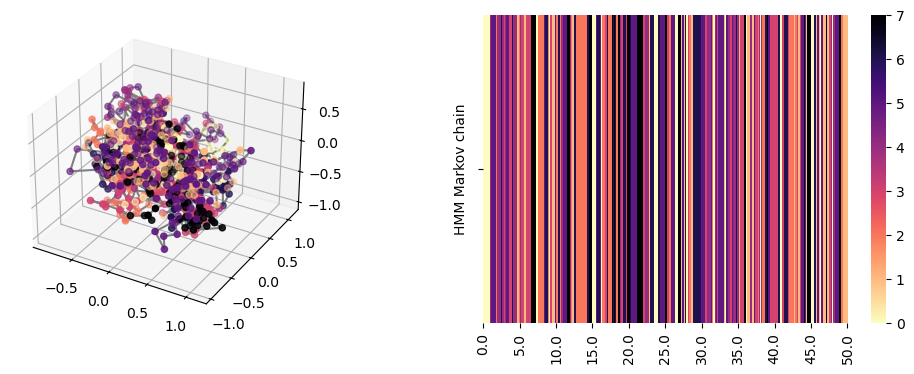

In [47]:
hmm = glhmm.glhmm(model_beta='no', K=8, covtype='full')
hmm.train(X=None, Y=np.transpose(X))
hmm_tc = hmmh.vector_time_course_to_tc(hmm.decode(X=None, Y=np.transpose(X),viterbi=True))
fig = plt.figure()
fig.set_size_inches(20,4)
axs=[0,0]
axs[1] = fig.add_subplot(1,3,2)
axs[0] = fig.add_subplot(1,3,1,projection='3d')
bidx = np.array(hmm_tc)
for i in range(0,8):
    cmap = matplotlib.cm.get_cmap('magma_r')
    rgba = cmap(i/7)
    axs[0].scatter(X[0,np.where(bidx==i)[0]], X[1,np.where(bidx==i)[0]], X[2,np.where(bidx==i)[0]], color = rgba)
axs[0].plot(X[0,], X[1,], X[2,], color = 'grey')
df = pd.DataFrame({"SSS":hmm_tc},index =t)
sns.heatmap(np.transpose(df),cmap='magma_r',ax=axs[1])
axs[1].set_xticks(np.linspace(0,1000,11))
axs[1].set_xticklabels(np.linspace(0,50,11))
axs[1].set_yticklabels('')
axs[1].set_ylabel('HMM Markov chain')
plt.show()

Init repetition 1 free energy = 5592.766993014107
Init repetition 2 free energy = 5615.295867271687
Init repetition 3 free energy = 5668.411978353449
Init repetition 4 free energy = 5550.079503738745
Init repetition 5 free energy = 5793.140980846328
Best repetition: 4
Cycle 1 free energy = 5605.995041714709
Cycle 2 free energy = 5547.645743690109
Cycle 3, free energy = 5547.318288059831, relative change = 0.005580670536147458
Cycle 4, free energy = 5547.261498745684, relative change = 0.0009668974707843359
Cycle 5, free energy = 5547.225329996243, relative change = 0.0006154317995264904
Cycle 6, free energy = 5547.179959253417, relative change = 0.000771413401585217
Cycle 7, free energy = 5547.113578228824, relative change = 0.0011273670976129177
Cycle 8, free energy = 5547.0160398577655, relative change = 0.0016537813117784954
Cycle 9, free energy = 5546.8849087260105, relative change = 0.0022184205164963206
Cycle 10, free energy = 5546.736123836644, relative change = 0.00251075947206

/var/folders/j3/3jf2wkbj5756yfdv4zjq5j300000gn/T/ipykernel_10588/4023026211.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma_r')


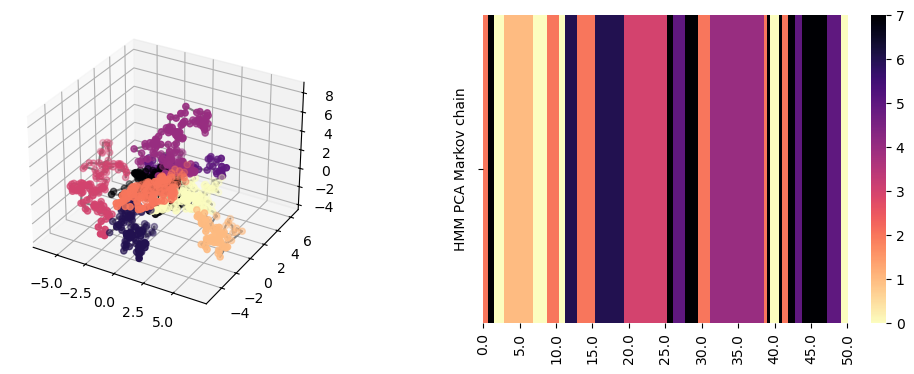

In [50]:
hmm = glhmm.glhmm(model_beta='no', K=8, covtype='full')
hmm.train(X=None, Y=np.transpose(X_pca))
hmm_tc = hmmh.vector_time_course_to_tc(hmm.decode(X=None, Y=np.transpose(X_pca),viterbi=True))
fig = plt.figure()
fig.set_size_inches(20,4)
axs=[0,0]
axs[1] = fig.add_subplot(1,3,2)
axs[0] = fig.add_subplot(1,3,1,projection='3d')
bidx = np.array(hmm_tc)
for i in range(0,8):
    cmap = matplotlib.cm.get_cmap('magma_r')
    rgba = cmap(i/7)
    axs[0].scatter(X_pca[0,np.where(bidx==i)[0]], X_pca[1,np.where(bidx==i)[0]], X_pca[2,np.where(bidx==i)[0]], color = rgba)
axs[0].plot(X_pca[0,], X_pca[1,], X_pca[2,], color = 'grey')
df = pd.DataFrame({"SSS":hmm_tc},index =t)
sns.heatmap(np.transpose(df),cmap='magma_r',ax=axs[1])
axs[1].set_xticks(np.linspace(0,1000,11))
axs[1].set_xticklabels(np.linspace(0,50,11))
axs[1].set_yticklabels('')
axs[1].set_ylabel('HMM PCA Markov chain')
plt.show()

In [51]:
kmeans = KMeans(n_clusters = 8).fit(np.transpose(X))
kmeans.labels_
fig = plt.figure()
fig.set_size_inches(20,4)
axs=[0,0]
axs[1] = fig.add_subplot(1,3,2)
axs[0] = fig.add_subplot(1,3,1,projection='3d')
bidx = np.array(kmeans.labels_)
for i in range(0,8):
    cmap = matplotlib.cm.get_cmap('magma_r')
    rgba = cmap(i/7)
    axs[0].scatter(X[0,np.where(bidx==i)[0]], X[1,np.where(bidx==i)[0]], X[2,np.where(bidx==i)[0]], color = rgba)
axs[0].plot(X[0,], X[1,], X[2,], color = 'grey')
df = pd.DataFrame({"SSS":box_idx_tc},index =t)
sns.heatmap(np.transpose(df),cmap='magma_r',ax=axs[1])
axs[1].set_xticks(np.linspace(0,1000,11))
axs[1].set_xticklabels(np.linspace(0,50,11))
axs[1].set_yticklabels('')
axs[1].set_ylabel('k-means Markov chain')
plt.show()

/Users/ramon/opt/anaconda3/envs/hmm/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/j3/3jf2wkbj5756yfdv4zjq5j300000gn/T/ipykernel_10588/783543047.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma_r')
